In [1]:
import os
import sys

In [2]:
home = os.environ['HOME']
work_path = os.path.join(home, 'far/farMe/uFunc')
src_path = os.path.join(home, 'far/PHARE')
build_path = os.path.join(home, 'far/builds/release/ufunc')

In [3]:
sys.path.append(os.path.join(src_path, "pyphare"))

In [4]:
import subprocess
import pyphare
import matplotlib.pyplot as plt
from pyphare.pharesee.run import Run
from pyphare.core.operators import dot, cross, sqrt, modulus, grad
from pyphare.core.ufuncs import gFilt, gF, peakIds
import numpy as np

In [5]:
run_path = os.path.join(work_path, 'wp')

In [6]:
if os.path.isdir(run_path):
    files = os.listdir(run_path)
else:
    files = []

In [7]:
if 'PYTHONPATH' in os.environ:
    os.environ['PYTHONPATH'] += os.pathsep + os.path.join(src_path, "pyphare")
else:
    os.environ['PYTHONPATH'] = os.pathsep + os.path.join(src_path, "pyphare")
os.environ['PYTHONPATH'] += os.pathsep + build_path

In [8]:
if 'ions_charge_density.h5' not in files :
    os.chdir(work_path)
    subprocess.run(['mpirun', '-n', '4', '/usr/bin/python3', work_path+'/wp.py', ], env=os.environ)    

In [9]:
run  = Run(run_path)
time = 0.0

In [52]:
V = run.GetVi(time)
type(V)

pyphare.pharesee.hierarchy.vectorfield.VectorField

In [57]:
for pls in V.patch_levels:
    for il, pl in pls.items():
        for p in pl:
            print(p.id)
            for k, v in p.patch_datas.items():
                print(k, v)
                print(dir(v.dataset))

p0#0
x FieldData: (box=(Box([300],[399]), [100]), key=x)
['__array__', '__bool__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__firstlineno__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getnewargs__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__nonzero__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setitem__', '__sizeof__', '__static_attributes__', '__str__', '__subclasshook__', '__weakref__', '_cache_props', '_d', '_dcpl', '_dxpl', '_e', '_extent_type', '_fast_read_ok', '_fast_reader', '_filters', '_id', '_is_empty', '_lapl', '_lcpl', '_readonly', '_selector', 'asstr', 'astype', 'attrs', 'chunks', 'compression', 'compression_opts', 'dims', 'dtype', 'external', 'fields', 'file', 'fillvalue', 'fletcher32', 'flush', 'id', 'is_scale', 'is_virtual', 'iter_chunks', 'len', 'make_scale', 'maxshape', 'name', 'nbytes', 'n

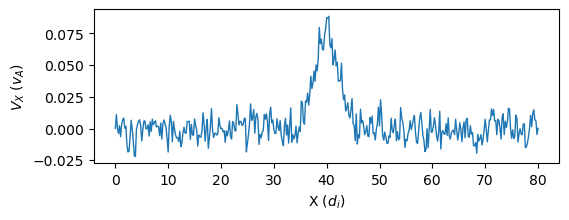

In [11]:
fig, ax = plt.subplots(figsize=(6,2))

Vi.plot(qty='x', ax=ax, ls='solid', lw=1.0, color='tab:blue', xlabel='X ($d_i$)', ylabel='$V_X$ ($v_A$)')

# define the domain, grid and function to work on

In [12]:
step = 0.2         # grid size
Nx = 50            # total number of grid point in the full domain
L = Nx*step        # total size of the domain
num_of_ghosts = 2  # num of ghosts
# half = 20          # position in index of where the first box is ending and the second is starting
# sep = half*step    # where is the separation between the 2 patches in physical units

In [13]:
def f(x):
    y = x+0.4
    return np.exp(-0.1*y**2)*y

def g(x):
    return f(x)+np.random.rand(x.shape[0])*0.4-0.2

def h(x):
    return (1.4+np.sin(2*np.pi*x/L))*0.4

In [14]:
x = np.arange(0, L+2*num_of_ghosts*step, step)-num_of_ghosts*step+0.5*step
y = f(x)
z = g(x)
u = h(x)

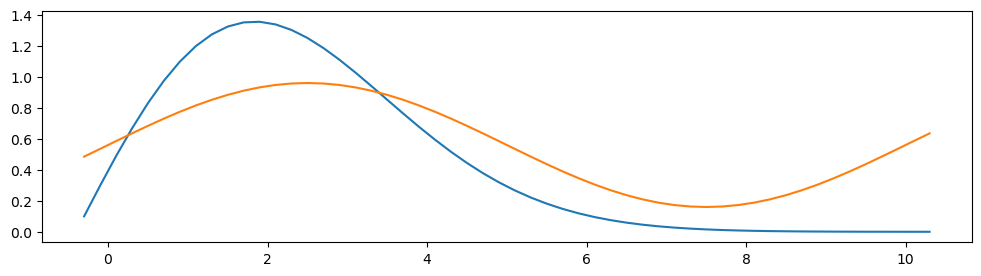

In [15]:
fig, ax = plt.subplots(figsize=(12, 3))

plt.plot(x, y)
plt.plot(x, u)
# plt.plot([sep, sep], [0, 1.3], 'k:')

# define the mock of a patch and a hierarchy

In [16]:
class Patch():
    def __init__(self, data, idx, name="unnamed", num_of_ghosts=2):
        assert(data.shape == idx.shape)
        self.data = np.asarray(data)
        self.nx = self.data.shape[0]
        self.idx = np.asarray(idx)
        self.name = name
        self.num_of_ghosts = num_of_ghosts

    def __add__(self, other):
        if _disables_array_ufunc(other):
            return NotImplemented
        assert(self.data.shape == other.data.shape)
        return Patch(np.add(self.data, other.data), self.idx, self.num_of_ghosts)

    def __mul__(self, other):
        if _disables_array_ufunc(other):
            return NotImplemented
        return np.multiply(self, other)

    def __array__(self, dtype=None):
        """ this is the numpy array protocol"""
        return np.asarray(self.data, dtype=dtype)

    def __array_ufunc__(self, ufunc, method, *inputs, **kwargs):
        print(f"__array_function__ de Patch appelé pour {ufunc.__name__}")
        if method != "__call__":
            raise NotImplementedError

        unwrapped = [i.data if isinstance(i, Patch) else i for i in inputs]
        result = getattr(ufunc, method)(*unwrapped, **kwargs)

        if isinstance(result, np.ndarray):
            return Patch(result, self.idx, name=ufunc.__name__+"@"+self.name, num_of_ghosts=self.num_of_ghosts)

    def __array_function__(self, func, types, args, kwargs):
        print(f"__array_function__ de Patch {func.__name__} appelé avec {[getattr(a, 'name', a) for a in args]}")
    
        unwrapped = [a.data if isinstance(a, Patch) else a for a in args]
        result = func(*unwrapped, **kwargs)
    
        if isinstance(result, np.ndarray):
            return Patch(result, self.idx, name=func.__name__+"@"+self.name, num_of_ghosts=self.num_of_ghosts)
        else:
            return result

    def __repr__(self):
        return """
        name : {0}
        data : {1}
        idx  : {2}
        nx   = {3}""".format(self.name, self.data, self.idx, self.nx)

In [17]:
sep = [20, 30, ]                      # contain the index of the boundaries of each patches w. a total number of patches == len(sep)+1
bounds = sep                      # these are all the separators
bounds = [0]+bounds               # then add the first point
bounds.append(Nx)                 # and the last one
boxes = [i*step for i in bounds]  # same as bounds bu in physical units, not indices
print(bounds, boxes)

[0, 20, 30, 50] [0.0, 4.0, 6.0, 10.0]


In [18]:
def fillPatch(id, func, box, step, num_of_ghosts=num_of_ghosts, name="unnamed"):
    idx = np.arange((box[0]-num_of_ghosts+0.5)*step, (box[1]+num_of_ghosts+0.5)*step, step)
    data = func(idx)
    return Patch(data, idx, name)

In [19]:
num_of_patches = len(bounds)-1
patches = []
print(num_of_patches)

for i in range(num_of_patches):
    print(i, bounds[i:i+2])
    patches.append(fillPatch(i, f, bounds[i:i+2], step, name=(f.__name__+str(i))))

3
0 [0, 20]
1 [20, 30]
2 [30, 50]


In [20]:
patches

[
         name : f0
         data : [0.09990005 0.29731211 0.48765496 0.66652679 0.82997432 0.97463736
  1.09786157 1.19777433 1.27332075 1.3242601  1.35112468 1.3551459
  1.33815357 1.30245608 1.25070918 1.18578157 1.1106245  1.02815195
  0.94113642 0.85212381 0.76336955 0.67679627 0.59397229 0.5161089 ]
         idx  : [-0.3 -0.1  0.1  0.3  0.5  0.7  0.9  1.1  1.3  1.5  1.7  1.9  2.1  2.3
   2.5  2.7  2.9  3.1  3.3  3.5  3.7  3.9  4.1  4.3]
         nx   = 24,
 
         name : f1
         data : [0.76336955 0.67679627 0.59397229 0.5161089  0.44407368 0.37841664
  0.31940571 0.26706802 0.22123411 0.18158205 0.14767945 0.11902159
  0.09506468 0.07525353]
         idx  : [3.7 3.9 4.1 4.3 4.5 4.7 4.9 5.1 5.3 5.5 5.7 5.9 6.1 6.3]
         nx   = 14,
 
         name : f2
         data : [1.47679451e-01 1.19021591e-01 9.50646756e-02 7.52535294e-02
  5.90436317e-02 4.59176724e-02 3.53970905e-02 2.70492235e-02
  2.04907919e-02 1.53884625e-02 1.14572113e-02 8.45713779e-03
  6.18929658e-03 4.

In [21]:
def _list_mean(x, *args, **kwargs):
    if not isinstance(x, Hierarchy):
        return NotImplemented

    return NamedArrayList([
        np.mean(a, *args, **kwargs)
        for a in x.arrays
    ])

def _list_add(x, y):
    if not isinstance(x, Hierarchy) or not isinstance(y, Hierarchy):
        return NotImplemented
    if len(x) != len(y):
        raise ValueError("Hierarchy length mismatch")

    return Hierarchy([
        np.add(a, b) for a, b in zip(x.arrays, y.arrays)
    ])

_LIST_HANDLED_FUNCTIONS = {
    np.mean: _list_mean,
    np.add:  _list_add,   # optional, ufunc already covers this
}

In [22]:
class Hierarchy():
    def __init__(self, patches, boxes):
        if not all(isinstance(a, Patch) for a in patches):
            raise TypeError("each elements of the patches list has to be a Patch")
        self.patches = list(patches)
        # self.numOfPatches = len(self.patches)
        self.boxes = boxes

    def __len__(self):
        return len(self.patches)

    def __repr__(self):
        r = ""
        for i, p in enumerate(self.patches):
            o = "{0} \n".format(p)
            r += o
        return r

    def __array_ufunc__(self, ufunc, method, *inputs, **kwargs):
        print(f"__array_function__ de Hierarchy appelé pour {ufunc.__name__}")
        if method != "__call__":
            return NotImplemented

        # Collect per-argument sequences
        seqs = []
        for x in inputs:
            if isinstance(x, Hierarchy):
                seqs.append(x.patches)
            else:
                seqs.append([x] * len(self))

        # Outer length must match
        n = len(seqs[0])                        # length of the first hierarchy
        if not all(len(s) == n for s in seqs):  # each of the other hierarchies have to be homogeneous
            raise ValueError("Hierarchy length mismatch")

        # Pairwise application
        result = [
            ufunc(*elems, **kwargs)
            for elems in zip(*seqs)
        ]

        return Hierarchy(result, self.boxes)

    def __array_function__(self, func, types, args, kwargs):
        print(f"__array_function__ de Hierarchy {func.__name__} appelé avec {[getattr(a, 'name', a) for a in args]}")
        if func not in _LIST_HANDLED_FUNCTIONS:
            return NotImplemented
        return _LIST_HANDLED_FUNCTIONS[func](*args, **kwargs)

    def __repr__(self):
        s = ""
        for i, p in enumerate(self.patches):
            s += p.__repr__()+"\n"
        return s

    def plot(self, **kwargs):
        fig, ax = plt.subplots(figsize=(12, 3))

        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
        markers = ["o", ".", "s", "*", "p", "P", "X", "D", "h", "p"]
        
        for i, p in enumerate(self.patches):
            ax.plot(p.idx, p.data, color=colors[i], marker=markers[i])

        ax.axvline(boxes[0] , ls='-', c='k')
        for x in boxes[1:-1]:
            ax.axvline(x, ls=':', c='k')
        ax.axvline(boxes[-1], ls='-', c='k')

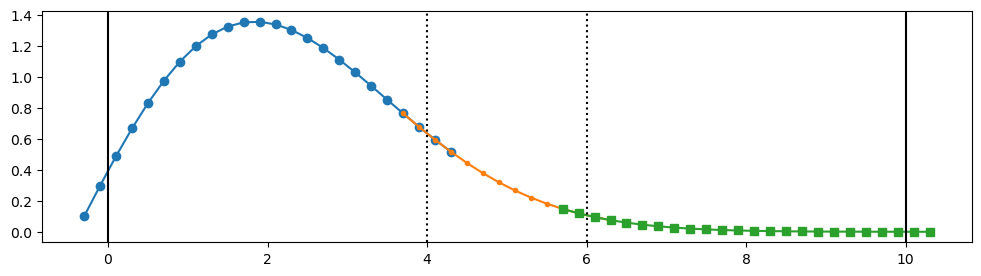

In [24]:
hy.plot()

In [25]:
new_patches = [np.sqrt(p) for p in patches]

__array_function__ de Patch appelé pour sqrt
__array_function__ de Patch appelé pour sqrt
__array_function__ de Patch appelé pour sqrt


In [26]:
hn = Hierarchy(new_patches, boxes)

In [23]:
hy = Hierarchy(patches, boxes)

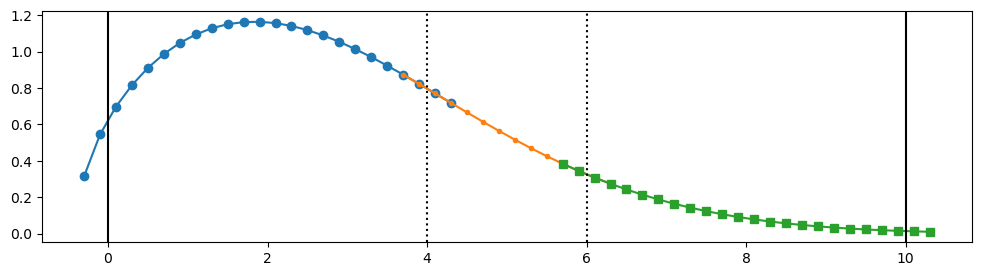

In [27]:
hn.plot()

In [28]:
hm = np.sqrt(hy)

__array_function__ de Hierarchy appelé pour sqrt
__array_function__ de Patch appelé pour sqrt
__array_function__ de Patch appelé pour sqrt
__array_function__ de Patch appelé pour sqrt


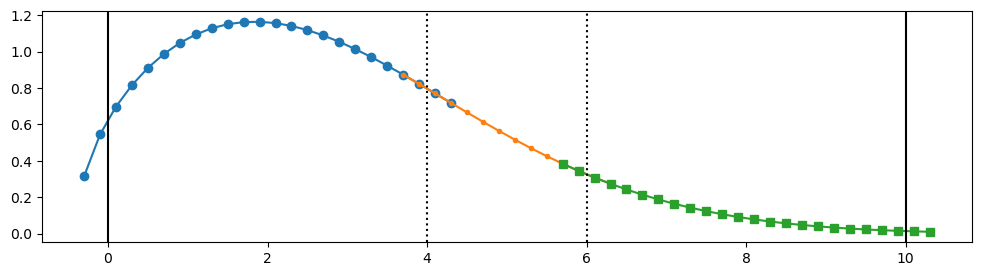

In [29]:
hm.plot()